# THings to fix, improve, add, and general outcome of this tool
Fix:
not fix per se. but this version work on the presentation of the notebook, i.e **turn into input mode mixtre of colabForms and ipywidgets (05.03.24)**

Improve:

    1) fix paralell heat map - issues with large alignment with many insertions <- still an issue, much deeper than origional problem (04/03/24)

    2) add code to search for multiple residues and consecutive/conseved motif

    3) remove '-' insertions from sequence before running miniSCA to unbias 1D heatmap <-- this is concensus sequence, but can do better? (05/03/24)

    4) create biophysical protein sequence and model (pdb) - martini forcefeild?

  5) include 1D Dssp above sequence and or heatmap (https://www.biotite-python.org/examples/gallery/structure/transketolase_sse.html) \
  
  (https://www.google.com/imgres?imgurl=x-raw-image%3A%2F%2F%2Fa5a961716617fd32a616ec8093e45812b5bee51b66e33b234222c4fbedf09520&tbnid=Mv0XZnFhqaX8XM&vet=10CAwQxiAoCGoXChMIqNv2vPLThAMVAAAAAB0AAAAAEAc..i&imgrefurl=https%3A%2F%2Fi11www.iti.kit.edu%2F_media%2Fteaching%2Ftheses%2Fba-eric-sallermann-14.pdf&docid=p2-Ti9Aq2hQ_2M&w=962&h=527&itg=1&q=2D%20dssp%20drawing%20python&ved=0CAwQxiAoCGoXChMIqNv2vPLThAMVAAAAAB0AAAAAEAc)
  
   (https://i11www.iti.kit.edu/_media/teaching/theses/ba-eric-sallermann-14.pdf)

(https://biopython.org/DIST/docs/tutorial/Tutorial.html)

Add:

  AlphaFold2 - fold concensus (majority rules) sequence


# General outcome:
 this tool is to perfom quick and simple bioinformatic analysis on proteins. The pipeline begins with an alignment file and visualises the conservation and mutaitons better than commercial tools. THe goal is to have (inorder of importance) a 1) colab version, 2) jupyter-notebook version, and 3) python program. This tools has no official name and is reffered to align_aminoacid

# BIG NOTE: 04.03.24
large alignments with many insertions and little to no conservation (highly mutable proteins) have difficult time producting approproate data.

Need to impliment or warn about using datasets like this. INclude the RT data set in examples for either (i) how to deal wit alignments like this or (ii) datasets to avoid atm.

# install packages required

In [ ]:
#@title setup **Align packages** hit play to run cell (~2m)
%%time
import os, time, signal
import sys, random, string, re
!{sys.executable} -m pip install Bio seqlogo
!apt-get install ghostscript pdf2svg
##Load Packages
#normal data manipulation packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import pylab
from matplotlib import pyplot as plt
#Bio.Python
from Bio import Phylo, AlignIO, SeqIO
from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import MuscleCommandline, ClustalwCommandline
# SeqLogo
import seqlogo


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pdf2svg is already the newest version (0.2.3-2).
ghostscript is already the newest version (9.55.0~dfsg1-0ubuntu5.6).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
CPU times: user 147 ms, sys: 11.6 ms, total: 159 ms
Wall time: 15.5 s


# sequence alignment and phylogenetic tree
### go to MUSCLE to input fasta sequence for alignment
### https://www.ebi.ac.uk/Tools/msa/muscle/
### adapted from Mohit Poudel's guide on phylotree creation (https://medium.com/@poudelmohit59/beginners-guide-to-phylogenetic-tree-construction-using-biopython-5accbd8345a2)


In [ ]:
#@title Import alignment file from **MUSCLE** or other alignment tool
align = AlignIO.read("RT_alignment.clw.txt", "clustal")
#print to see if data is there
print(align)

# if have single sequence. please see code after seqLogo, for construction of pre-alignment file 'Large sequnce file creation.'
# if have multiple sequences from NCBI in the following formats () please see ncbi_batchclean_workflow.txt to prep files for alignment

Alignment with 133 rows and 534 columns
-------------------------------------------K...--- sp|P19560.2|POL_BIV29
-------------------------------------------K...--- sp|Q9TTC1.2|POL_KORV
------------------------------------------VV...--- sp|Q4U0X6.4|POL_HTL3P
--------------------------------------------...--- sp|P25059.2|POL_BLVAU
------------------------------------------YQ...--- sp|Q91DM0.1|POLG_PVCV1
--------------------------------------------...--- sp|P03554.1|POL_CAMVS
--------------------------------------------...--- sp|P03555.1|POL_CAMVC
-----------------------------------PIMVKIADG...--- sp|P33459.1|POL_CAEVC
--------------------------------------------...--- sp|P18802.3|POL_HV1ND
--------------------------------------------...--- sp|P16901.1|POL_OMVVS
--------------------------------------------...--- sp|P12451.3|POL_HV2SB
--------------------------------------------...--- sp|P15833.3|POL_HV2D2
--------------------------------------------...--- sp|P18096.4|POL_HV2BE
-----------

In [ ]:
# Isolate id from alignment file
ids = []
# searches for record in alignment
for record in align:
#prints id + amino acid length
    print("%s %i" % (record.id, len(record)))
#stors id in list for use later on. This is in the order of the origional alignment file.
    if record.id not in ids:
        ids.append(record.id)

ids

#### Turn Bio results into pandas df, print the two types to get an idea of how pandas arranges the data##

In [ ]:
df = pd.DataFrame(data = align)
# append and save dataframe, Ordering of ids will depend on the origional clustal file ordering
df['Ids'] = ids
#print to see df
print(df)

## Concensus seq generation, conserved, and mutated residue stats

### (majority rules ) Concensus seq generation and conserved

In [ ]:
# quick stats on alignment
# generates majority rules concencuss sequence/residues in their position with highest freq
stat = df.describe()#.to_csv('./descibe.csv')
# transpose from wide to long df
s = stat.transpose()
# replace inserts with non amino acid letter
ddf = s.replace('-', 'X')
#remove 'inserts'
df1 = ddf.drop(ddf[ddf['top'] == 'X'].index)
#drop unecessary columns
df1.drop(list(df1.filter(regex='count|unique|freq')), axis=1, inplace=True)
# move back to wide df
d = df1.transpose()
# remove unecessary column
d.drop(list(d.filter(regex='Ids')), axis=1, inplace=True)
#save conserved residues and positions to file
d.to_csv('describe.csv')
#turn list from above code to dict for heatmaps
df_dict = d.to_dict('list')
print(df_dict)

{75: ['P'], 82: ['K'], 83: ['K'], 86: ['T'], 87: ['K'], 88: ['W'], 89: ['R'], 90: ['K'], 91: ['L'], 92: ['V'], 93: ['D'], 96: ['F'], 97: ['R'], 98: ['E'], 99: ['L'], 100: ['N'], 101: ['K'], 107: ['R'], 108: ['T'], 109: ['Q'], 110: ['D'], 114: ['F'], 115: ['W'], 116: ['E'], 117: ['V'], 119: ['Q'], 120: ['L'], 121: ['G'], 131: ['I'], 132: ['P'], 133: ['H'], 134: ['P'], 137: ['A'], 138: ['G'], 139: ['L'], 145: ['K'], 146: ['K'], 147: ['K'], 149: ['K'], 150: ['S'], 155: ['V'], 156: ['T'], 157: ['V'], 158: ['L'], 159: ['D'], 160: ['V'], 170: ['G'], 171: ['D'], 172: ['A'], 173: ['Y'], 174: ['F'], 178: ['S'], 179: ['V'], 183: ['P'], 184: ['L'], 185: ['D'], 191: ['E'], 192: ['D'], 193: ['F'], 194: ['R'], 195: ['K'], 196: ['Y'], 197: ['T'], 198: ['A'], 199: ['F'], 205: ['T'], 206: ['I'], 207: ['P'], 221: ['I'], 222: ['N'], 223: ['N'], 224: ['E'], 225: ['T'], 236: ['P'], 237: ['G'], 238: ['I'], 239: ['R'], 265: ['Y'], 266: ['Q'], 267: ['Y'], 269: ['N'], 270: ['V'], 271: ['L'], 272: ['P'], 273: [

### input sequence for Alphafold2 (conserved sequence) (05/03/24)

In [ ]:
con = pd.DataFrame.from_dict(df_dict)

### Conserved residues

#### needs fixing for large alignment (04.03.24)

In [ ]:
#Save conserved amino acids
#Look for conservation across all rows and columns
conRes = df.loc[:,(df == d.iloc[0]).all()]
conRes['Ids'] = ids
conRes


<ipython-input-108-79d924ebed5f>:3: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  conRes = df.loc[:,(df == d.iloc[0]).all()]


""
0
1
2
3
4
...
128
129
130
131


In [ ]:

df.columns[df.apply(lambda x: 'P' in x.values)] ## AI generated


Index([  9,  29,  32,  33,  34,  35,  37,  40,  41,  43,
       ...
       457, 462, 463, 465, 468, 483, 485, 488, 504, 512],
      dtype='object', length=299)

#### Beginings of motif search function (04/03/24)

In [ ]:
#calculate statistics of amino acids in each position
stat1 = []
string = 'KK**TW'
# Iterate through each position (amino acid) in the protein (n positions)
for i in range(len(df.columns)): # THIS NEED TO MATCH THE NUMEBR OF AMINO ACIDS IN PROTEIN
# Calculate the frequency of each amino acid at the current position
   #stat1
   #ss = df[i].value_counts()
# Calculate the frequency of each amino acid at the current position (normalized)
   #stat2
   #ss = df[i].value_counts(normalize=True) # prints list of amino acid frequencies
    ss = df[i].value_counts(normalize=True).tolist() # as the line above but transposed values
    if i not in ss:
    #stat1.append(ss)
      stat1.append(ss)

# Convert the stat2 list of lists into a DataFrame
#pdstat1 = pd.DataFrame(stat1)
pdstat2 = pd.DataFrame(stat1)
pdstat2.transpose()
# Optionally, you can save the DataFrame to CSV files if needed
# pdstat1.to_csv('PRO_aminoacidSTAT.csv')
# pdstat2.to_csv('PRO_aminoacidSTAT_norm.csv')

In [ ]:
t = 'P'
w = 'M'
# iterate through each row and select
# 'Name' and 'Stream' column respectively.
for i in range(len(df.columns)):
  for ind in df.index:
    ss = df.columns[df.loc == t]
    if t in ss:
      stat1.append(ss)
    #print(df['Ids'][ind],df[ind])

<ipython-input-75-6d14fbf84f1e>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ss = df.columns[df.loc == t]


In [ ]:
stat1

In [ ]:
ss

array([], shape=(0, 535), dtype=object)

### Mutated residues

#### findout use for code after muRes (04/03/24)

In [ ]:
# create df with mutated residues
muRes = df.loc[:,~(df == df.iloc[0]).all()] #remove conserved residues from sequence
muRes['Ids'] = ids
#save only mutated residues to csv file
#muRes.to_csv('xticksmutations_2.csv')
## FIND OUT WHAT BELOW DOES AND IS GOOD FOR! - 04/03/24
#mutated residues in majority rules residues
ffy = d.loc[:,~(d == df.iloc[0]).all()]
print(ffy)
fft = d.loc[:,~(df == d.iloc[0]).all()]
print(fft)
print(df)

#### Insertions

In [ ]:
#save all insertion locations
ds = ddf.drop(ddf[ddf['top'] != 'X'].index) #drop not inserted resdues
ds.drop(list(ds.filter(regex='count|unique|freq')), axis=1, inplace=True) #drop unwanted columns
dds = ds.transpose() #transpose df to wide from long
ddsf = dds.replace('X', '-') # change wildcard letter X back to insertion
ddsf

,0,1,2,3,4,5,6,7,8,9,...,524,525,526,527,528,529,530,531,532,533
top,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


## create phylo tree

### UPGMATree

In [ ]:
# use the above alignemnt file to create a phylogeny tree
# Open and initiate the Distance Calculator using the Identity model
from Bio.Phylo.TreeConstruction import DistanceCalculator
calculator = DistanceCalculator('identity')

# Write the Distance Matrix
distance_matrix = calculator.get_distance(align)
print(distance_matrix)

# Create a DistanceTreeConstructor object
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
constructor = DistanceTreeConstructor()
# Construct the phlyogenetic tree using UPGMA algorithm
UPGMATree = constructor.upgma(distance_matrix)

In [ ]:
# Make a better looking tree using the features of matplotlib

fig = plt.figure(figsize=(20, 12), dpi=300) # create figure & set the size
matplotlib.rc('font', size=18)              # fontsize of the leaf and node labels
matplotlib.rc('xtick', labelsize=16)       # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=16)       # fontsize of the tick labels
axes = fig.add_subplot(1, 1, 1)

# drawing the tree
Phylo.draw(UPGMATree, axes=axes)
fig.savefig("UPGMATree")


In [ ]:
# find common ancestro of two clades
#select animals
UPGMATree.common_ancestor('Dog','Masked_Palm_Civet')
#get terminald
UPGMATree.count_terminals()
# get non terminals
UPGMATree.get_nonterminals()
# branch length of ancestors
UPGMATree.total_branch_length()

### NJTree (Neigbour joining algorithm)

In [ ]:
# Construct the phlyogenetic tree using NJ algorithm
NJTree = constructor.nj(distance_matrix)
# Draw the phlyogenetic tree using terminal
Phylo.draw_ascii(NJTree)

In [ ]:
# Make a better looking tree using the features of matplotlib

fig = plt.figure(figsize=(28, 11), dpi=300) # create figure & set the size
# matplotlib.rc('font', size=18)              # fontsize of the leaf and node labels
# matplotlib.rc('xtick', labelsize=16)       # fontsize of the tick labels
# matplotlib.rc('ytick', labelsize=16)       # fontsize of the tick labels


axes = fig.add_subplot(1, 1, 1)
Phylo.draw(NJTree, axes=axes)

fig.savefig("NJTree")

### Import multipul alignment files.

In [ ]:
##multipule data file
align1 = AlignIO.read("clustalo-I20200406-012943-0897-1425048-p2m.clustal_num", "clustal")
print(align1)
align2 = AlignIO.read("clustalo-I20200406-014019-0645-26828020-p2m.clustal_num", "clustal")
print(align2)
align3 = AlignIO.read("clustalo-I20200406-013054-0367-48373588-p2m.clustal_num", "clustal")
print(align3)
align4 = AlignIO.read("clustalo-I20200406-013931-0129-80505547-p2m.clustal_num", "clustal")
print(align4)
align5 = AlignIO.read("complete.clustal_num", "clustal")
print(align5)

## Statistical Coupling Analysis (SCA)
##https://reynoldsk.github.io/pySCA/
##https://github.com/ranganathanlab/pySCA
##https://github.com/reynoldsk/pySCA
##https://ranganathanlab.gitlab.io/pySCA/
##https://github.com/davidkastner/evoAllostery

# HeatMaps
    1) Global conserved residues
    2) Targeted conserved residues
    3) miniSCA


##1) Global conserved residues

##Seqmented Heatmap

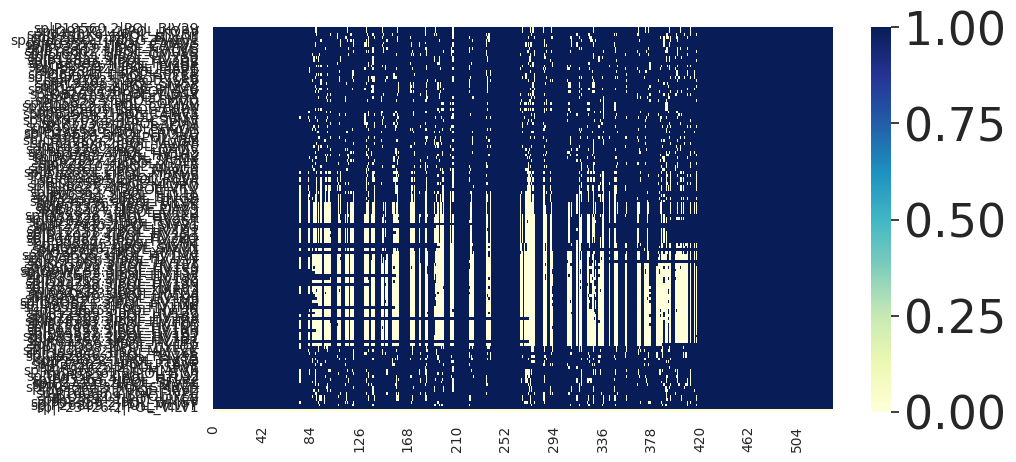

In [ ]:
# turn dictionary of conserved residues into df
vals = df_dict
#search of vals in origional df, turing them into boolean (True or False)
ff = df.isin(vals)
#Looks for matching aminoacids, using reverse find function. True = Conserved False = Substituted

#Look for conservation across all rows and columns
ft = df.eq(d.iloc[:, :], axis=1) #i.e. searcdhing for mutation/differences in sequence between origional df and mutated df
ft.replace({False: 0, True: 1}, inplace=True)
# create (segmented) df of positive/true and negative/false values for heatmap plotting
tt = ft.eq(ff.iloc[:, :], axis=1)

#Use new data frame of 1 and 0 to populate heat map (seaborn)
plt.figure(figsize=(10,5))
y_axis_labels = ids # manual input for labels for y-axis
#g = sns.heatmap(tt,cmap='YlGnBu')
g = sns.heatmap(tt, yticklabels=y_axis_labels,cmap='YlGnBu')
sns.set(font_scale=3)
g.tick_params(labelsize=10)
#pp.savefig('Spike_heatmap_conserved.pdf',bbox_inches='tight')

##Parallel Heatmap

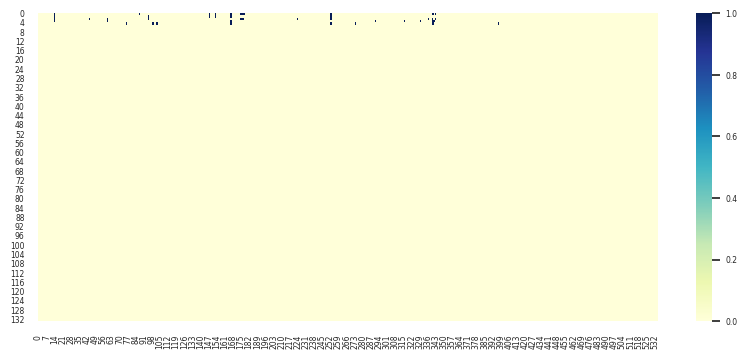

In [ ]:
#Looks for matching aminoacids, using reverse find function. True = substituted False = Same
#i.e. searcdhing for mutation/differences in the collagen
#Look for conservation across all rows and columns
ft = df.eq(dt.iloc[:, :], axis=1)
#Turn boolean values into numeric values by multiplying by 1
ft.replace({False: 0, True: 1}, inplace=True)
#Use new data frame of 1 and 0 to populate heat map (seaborn)
plt.figure(figsize=(10,4))
#x_axis_labels = [] # labels for x-axis
#y_axis_labels = [] # manual input for labels for y-axis
sns.set(font_scale=0.5)
g = sns.heatmap(ft,cmap='YlGnBu')
#g = sns.heatmap(ft, yticklabels=y_axis_labels,cmap='YlGnBu')
#g.tick_params(labelsize=10)
#plt.xticks(rotation=20)
plt.show()
#pp.savefig('Spike_heatmap_conserved.pdf',bbox_inches='tight')


##2) Targeted (conserved) residues

##### figure out difference between the two residue searches (04.03.24)

<Axes: >

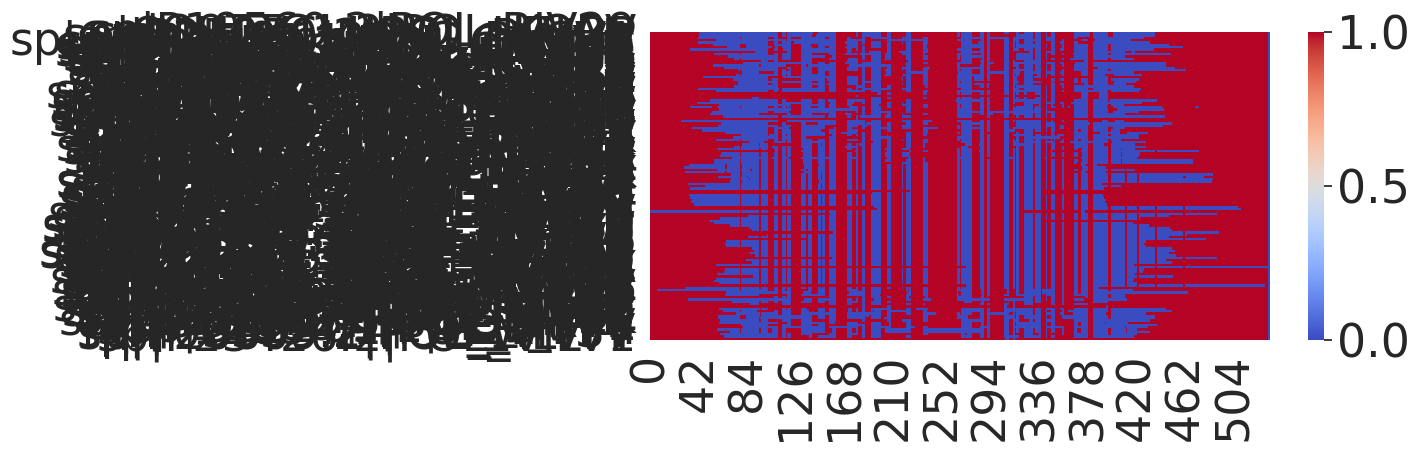

In [ ]:
#search of particular residues in the origional data frame
#uu = df.loc[0:].eq('G') # not sure what the difference of this compared to below command
uu = df.iloc[:].eq('-')
uu2 = df.iloc[:].eq('A')
 # search for particular residue in df and save as new df for plotting
#x_axis_labels =  # labels for x-axis
y_axis_labels = ids # manual input for labels for y-axis

plt.figure(figsize=(10,4))
sns.heatmap(uu, cmap="coolwarm", yticklabels=y_axis_labels)
#sns.heatmap(uu, cmap="coolwarm")

### Targeted (conserved) residues subplots (2 or more residues)

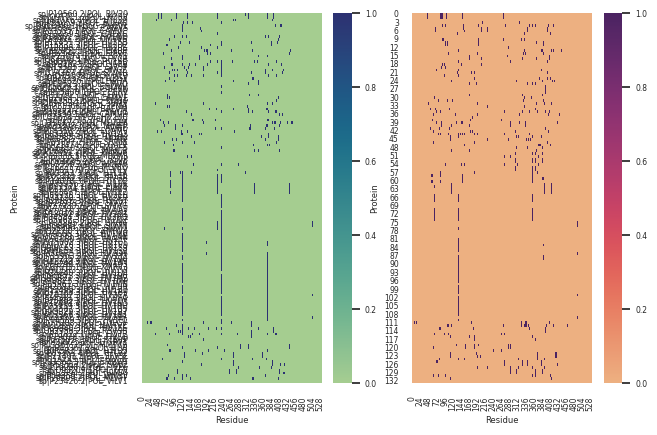

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2) # create subplot

sns.heatmap(uu, yticklabels=y_axis_labels, cmap="crest", ax=ax1)
sns.heatmap(uu2, ax=ax2, cmap="flare")

for ax in (ax1, ax2):
    ax.set_xlabel("Residue")
    ax.set_ylabel("Protein")

plt.show()

## 3) miniSCA

### finalise this code with first for loop (05.03.24)

In [ ]:
#calculate statistics of amino acids in each position
stat1 = []
stat2 = []

# Iterate through each position (amino acid) in the protein (n positions)
for i in range(402): # THIS NEED TO MATCH THE NUMEBR OF AMINO ACIDS IN PROTEIN or use 'for i in range(len(df)):'
# Calculate the frequency of each amino acid at the current position
   #stat1
   #ss = df[i].value_counts()
# Calculate the frequency of each amino acid at the current position (normalized)
   #stat2
   #ss = df[i].value_counts(normalize=True) # prints list of amino acid frequencies
    ss = df[i].value_counts(normalize=True).tolist() # as the line above but transposed values
    if i not in ss:
    #stat1.append(ss)
      stat2.append(ss)

# Convert the stat2 list of lists into a DataFrame
#pdstat1 = pd.DataFrame(stat1)
pdstat2 = pd.DataFrame(stat2)
pdstat2.transpose()
# Optionally, you can save the DataFrame to CSV files if needed
# pdstat1.to_csv('PRO_aminoacidSTAT.csv')
# pdstat2.to_csv('PRO_aminoacidSTAT_norm.csv')

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,1.0,1.0,1.0,1.0,1.0,1.0,0.6,1.0,0.4,0.8,...,1.0,1.0,1.0,1.0,0.8,0.8,1.0,1.0,1.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,0.4,0.2,...,NaN,NaN,NaN,NaN,0.2,0.2,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Plot 1D heatmap of stats generated from above

In [ ]:
ar2 = pdstat2.transpose()
#ar2 = pdstat1.transpose()
plt.figure(figsize=(3,40))
#sns.heatmap(ft, cmap='YlGnBu')
g = sns.heatmap(ar2, yticklabels=y_axis_labels, cmap='YlGnBu')
#pp.savefig('MOMP_conserved.pdf',bbox_inches='tight')

In [ ]:
#Searching for values equal to 1, i.e, conserved amino acids in all aligned protein
tt = pdstat2[pdstat2.eq(1.0000).any(axis=1)] #seaches based on the frequency list
t = tt.transpose().dropna()
column_names = list(t.columns.values)
#chqnges values of amino acids in the conserved indexes
#indices = [3,  15,  17,  23,  33,  37,  39,  42,  74,  94,  95, 114, 115,
#            116, 117, 121, 122, 150, 152, 153, 177, 181, 188, 200, 238]
indices = column_names
dff1 = df
dff1.T.loc[indices, 0: 5] = 1.0000

print(dff1.head(16))


   0    1    2    3    4    5    6    7    8    9    ...  392  393  394  395  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0   
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0   
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0  1.0   

   396  397  398  399  400 401  
0  1.0  1.0  1.0  1.0  1.0   F  
1  1.0  1.0  1.0  1.0  1.0   F  
2  1.0  1.0  1.0  1.0  1.0   F  
3  1.0  1.0  1.0  1.0  1.0   F  
4  1.0  1.0  1.0  1.0  1.0   F  

[5 rows x 402 columns]


# Biophysical properties

## After loading in packages, create aminop acid libraries in the order stated below
##Library 1 - Inhouse wild card values [Jj,Oo,Xx,Uu] Note B and Z can be used but for now (ver 1.2) only
##4 out of 6 wilde card are chooses. Please see document (Inhouse_wildcard_basic.txt for explination of library


AcidSma = 'D', 'S'

AcidLarge = 'E'


BasicSma = 'H'

BasicLarge = 'R','K'


HPolSma = 'T'

HPolLarge = 'N', 'Q'


HnonSma = 'G', 'P', 'A', 'V'

HnonLarge = 'C', 'I', 'L', 'M', 'F', 'Y', 'W'


  AcidicSma = 'j'

  AcidicLarge = 'J'

  BasicSma = 'o'

  BasicLarge = 'O'

  HPolSma = 'x'

  HPolLarge = 'X'

  HnonSma = 'u'

  HnonLarge = 'U'

In [ ]:
## Amino acids are classified into groups on physical bulkiness
AcidSma = 'D', 'S'
AcidLarge = 'E'

BasicSma = 'H'
BasicLarge = 'R','K'

HPolSma = 'T'
HPolLarge = 'N', 'Q'

HnonSma = 'G', 'P', 'A',
HnonLarge = 'C', 'I', 'L', 'M', 'F', 'Y', 'W', 'V'

In [ ]:
##amino acid groups are assigned uniq identifier
AcidSma = 'j'
AcidLarge = 'J'
BasicSma = 'o'
BasicLarge = 'O'
HPolSma = 'x'
HPolLarge = 'X'
HnonSma = 'u'
HnonLarge = 'U'

In [ ]:
# creation of correlation matrix
#http://what-when-how.com/molecular-biology/van-der-waals-surface-volume-molecular-biology/

#Van der Waals surface of Average volume of buried residue (A residue is defined as buried if 5% or less of its potential accessible surface area is available to solvent contact)

data = {'A':  [91.5],
'R':  [202],
'N':  [135.2],
'D':  [124.5],
'C':  [105.6],
'E':  [161.1],
'Q':  [155.1],
'G':  [66.4],
'H':  [167.3],
'I':  [168.8],
'L':  [167.9],
'K':  [171.3],
'M':  [170.8],
'F':  [203.4],
'P':  [129.3],
'S':  [99.1],
'T':  [122.1],
'W':  [237.6],
'Y':  [203.6],
'V':  [141.7],
        }

data
# creation of DataFrame
df = pd.DataFrame(data)
#matrix = read_csv('VdWRadiusMatrix.csv')
corrM = df.corr()


In [ ]:
# scoring function of biophysical attributes
AcidicSma = -2
AcidicLarge = -1
BasicSma = 2
BasicLarge = 1
HPolSma = 0.25
HPolLarge = 0.5
HnonSma = -0.25
HnonLarge = -0.5
Nan = 0

### Convert residues to biophysical properites

In [ ]:
# convert amino acids into pysiochemical properties
#Conserved residues only
cc = conRes.replace(['R', 'K'], BasicLarge).replace(['C', 'I', 'L', 'M', 'F', 'Y', 'W'], HnonLarge).replace(['G', 'P', 'A', 'V'],HnonSma).replace(['D', 'S'], AcidSma).replace(['E'], AcidLarge).replace(['T'], HPolSma).replace(['H'], BasicSma).replace(['N', 'Q'], HPolLarge)
# whole dataframe
cc2 = df.replace(['R', 'K'], BasicLarge).replace(['C', 'I', 'L', 'M', 'F', 'Y', 'W'], HnonLarge).replace(['G', 'P', 'A', 'V'],HnonSma).replace(['D', 'S'], AcidSma).replace(['E'], AcidLarge).replace(['T'], HPolSma).replace(['H'], BasicSma).replace(['N', 'Q'], HPolLarge)
df1 = pd.DataFrame(cc2)
df1['Ids'] = ids
print(df1)
#df.to_csv('BulkySpike.csv')


In [ ]:
cc = conservedRange2.replace(['R', 'K'], BasicLarge).replace(['C', 'I', 'L', 'M', 'F', 'Y', 'W'], HnonLarge).replace(['G', 'P', 'A', 'V'],HnonSma).replace(['D', 'S'], AcidicSma).replace(['E'], AcidicLarge).replace(['T'], HPolSma).replace(['H'], BasicSma).replace(['N', 'Q'], HPolLarge).replace(['N', 'Q'], HPolLarge).replace(['-'], Nan)
#print(cc)
df = pd.DataFrame(cc)
#df['Ids'] = RTids
print(df)
pp.figure(figsize=(30,16))
sns.heatmap(df)
#df.to_csv('RT_BigCON_sizes.csv')

# SeqLogo

https://www.tije.co/post/seqlogo_from_multiple_sequence_alignment/

In [ ]:
# Load in MUSCLE alignment data or use existing data frame
#align = AlignIO.read("muscle-I20240202-023137-0249-37608114-p1m-aln-clustalw.txt", "clustal")
align = align

In [ ]:
# define seqlogo function
def alnSiteCompositionDF(aln, characters="ACDEFGHIKLMNPQRSTVWY"):
  alnRows = aln.get_alignment_length()
  compDict = {char:[0]*alnRows for char in characters}
  for record in aln:
    header = record.id
    seq = record.seq
    for aaPos in range(len(seq)):
      aa = seq[aaPos]
      if aa in characters:
        compDict[aa][aaPos] += 1
  return pd.DataFrame.from_dict(compDict)

In [ ]:
# create seqlogo
momp = alnSiteCompositionDF(align) # apply above function to df
momp_alignmentSiteFreqDF = momp.div(momp.sum(axis=1), axis=0) # add normalise statistic values to df from seqlogo function
#create seqlogo
momp_alignmentSiteFreqSeqLogo = seqlogo.Ppm(momp_alignmentSiteFreqDF,alphabet_type="AA")
seqlogo.seqlogo(momp_alignmentSiteFreqSeqLogo, ic_scale = True, format = 'svg', size = 'xlarge',filename = './MompSeqlogo.svg')

# Large sequnce file creation.


In [ ]:
#import our three important packages
from Bio import SeqIO
from Bio import AlignIO
from Bio import Phylo

In [ ]:
# import sequence sand specify format
p1 = SeqIO.read("seq1.fasta", "fasta")
p2 = SeqIO.read("seq2.fasta", "fasta")
p3 = SeqIO.read("seq3.fasta", "fasta")
p4 = SeqIO.read("seq4.fasta", "fasta")
...
p12 = SeqIO.read("seq12.fasta", "fasta")

In [ ]:
# assidn easy to read id for phylotree
p1.id = 'Animal_1'
p2.id = 'Animal_2'
p3.id = 'Animal_3'
p4.id = 'Animal_4'
...
p12.id = 'Animal_12'

In [ ]:
# create combined sequence file
combined_sequence = SeqIO.write([p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12], "combined_sequence.fasta", "fasta")

# Misc code